# What makes a national soccer player, in search within Random Forest

## Overview

In high school years, I played FIFA, Championship Manager and Football Manager Series quite a bit alongside many strategy games and accomplished this work as a prolongation of my early interests.

This projects aims to predict  if the soccer players have participated in their national team or not.
As  the result, we successfully obtained 94.9% accuracy, 97.8% recall and 95.1% f-beta scores for training set. 

Also we achieved 83.9% accuracy, 89.5% recall and 87.4% f-beta scores for the completely seperate previously unseen validation set.

With this project, we will use 2 different kaggle dataset as well as additional data which I scraped from a website.

As usual in the industry, the datasets had a considerable amount of null values, outliers and moreover were in need of various brand new features to be created. So I derieved many novel features that I thought could contribute the prediction power of our model, based on my foresight. And those worked indeed and increased the performance metrics by 28-34%.

Lastly, this project reflects data with a wide variety of illustrations. At the end of the work, I inwestigated the wrongly predicted minority of instances and have sought further ways to improve the results.

World Heat Map That Displays Player Distrubution by Country


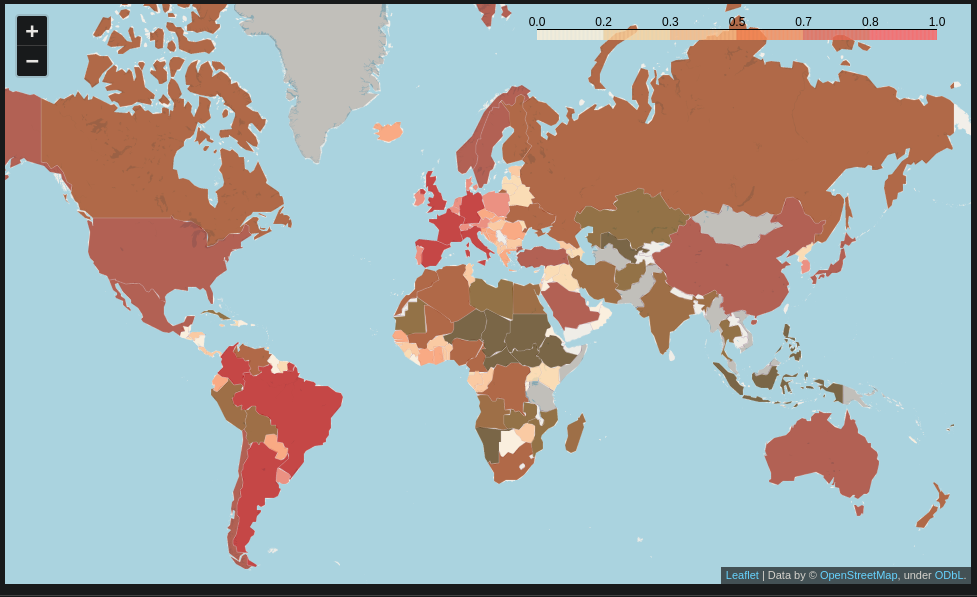

In [1]:
from IPython.display import Image
print("World Heat Map That Displays Player Distrubution by Country")
Image(filename='world_heat_map_player_count_distrubution.png')

# Table Of Contents


    • Title
        ◦ Overview And Results in Advance
        ◦ World Heat Map instance for intro
        ◦ Table Of Contents
        ◦ import libraries and datasets
        ◦ Feature Correlation (heat map)
        ◦ Extract World Club Rankings via Beautiful Soup
        ◦ Matching Club Data
            ▪ Manual Correction of Some Wrong Records
        ◦ Binning of The Ranked Soccer Clubs
        ◦ First of all, lets derive our prospective target feature 'national_player' (feature creation)
        ◦ Missing Values Treatment
            ▪ An overview on null and possible problematic values/features
                • First let's drop evidently irrelevant features
                • Null Value Percentage By Feature
            ▪ Handling Missing Data
                • Special Cases
                    ◦ remove € sign and convert into numeric value K 1000 and M 1.000.000
                    ◦ remove lbs expression from weight
                    ◦ remove ' and convert numeric (1 foot == 12 inches)
                    ◦ remove + sign and sum up both Operand
                • Filling NA values
                    ◦ missing columns to be assigned as median
                    ◦ missing columns to be assigned as mode
                    ◦ missing columns to be assigned as unknown
        ◦ Let's investigate our data
            ▪ World Heat Map Stats By Country via Folium
                • Player Counts by Country in 'data'
                • Number of Precious Players by Country in 'data' (> &#36;5,000,000)
        ◦ Match players in FIFA 19 dataset with the ones in Football Manager 2017 in order to retrieve national_player feature
            ▪ Match Nationality And NationID
            ▪ Let's start to build up our nationality dictionary with 50 nations
            ▪ Match players from 2 datasets
        ◦ Distribution of the target value (Graphs)
        ◦ Outlier Treatment
            ▪ Histograms
            ▪ So we will shrink those features via logarithmic function in order to acquire a more meaningful set of values for the training.
            ▪ Shrunk Feature Histograms
        ◦ More Feature Creation
            ▪  Creating positionID by utilizing following columns
            ▪ Creation of distance of each player's key features from his segment's mean, max and median
        ◦ Checkpoint
        ◦ Normalization
            ▪ One Hot Encoder & MinMaxScaler
        ◦ Training The Model
            ▪ Split the data frame into 2 completely separate pieces, shuffle the rows and keep 2nd half for test
            ▪ Up-Sampling
            ▪ Train Set Performance
            ▪ Validation Set Performance
        ◦ Further Investigation False Prediction Distributions
        ◦ Conclusion And Findings


#### importing libraries and 2 datasets

In [3]:
#sources 
#https://www.kaggle.com/ajinkyablaze/football-manager-data
#https://www.kaggle.com/karangadiya/fifa19
#https://footballdatabase.com/ranking/world/1
#https://github.com/python-visualization/folium/blob/master/examples/data/world-countries.json


from pandas.plotting import scatter_matrix
from time import time
from datetime import datetime  
from datetime import timedelta 
from IPython.display import display 
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.cluster import KMeans
import math 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from statistics import mean

#https://github.com/nalepae/pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=5)


# player data from Football Manager 2017 dataset
data_fm = pd.read_csv('fm_player_stats.csv')

# player data from Fifa 19 dataset
data = pd.read_csv('fifa19.csv')

#countries world-countries.json
world_countries_json_source = 'world-countries.json'



INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Feature Correlation

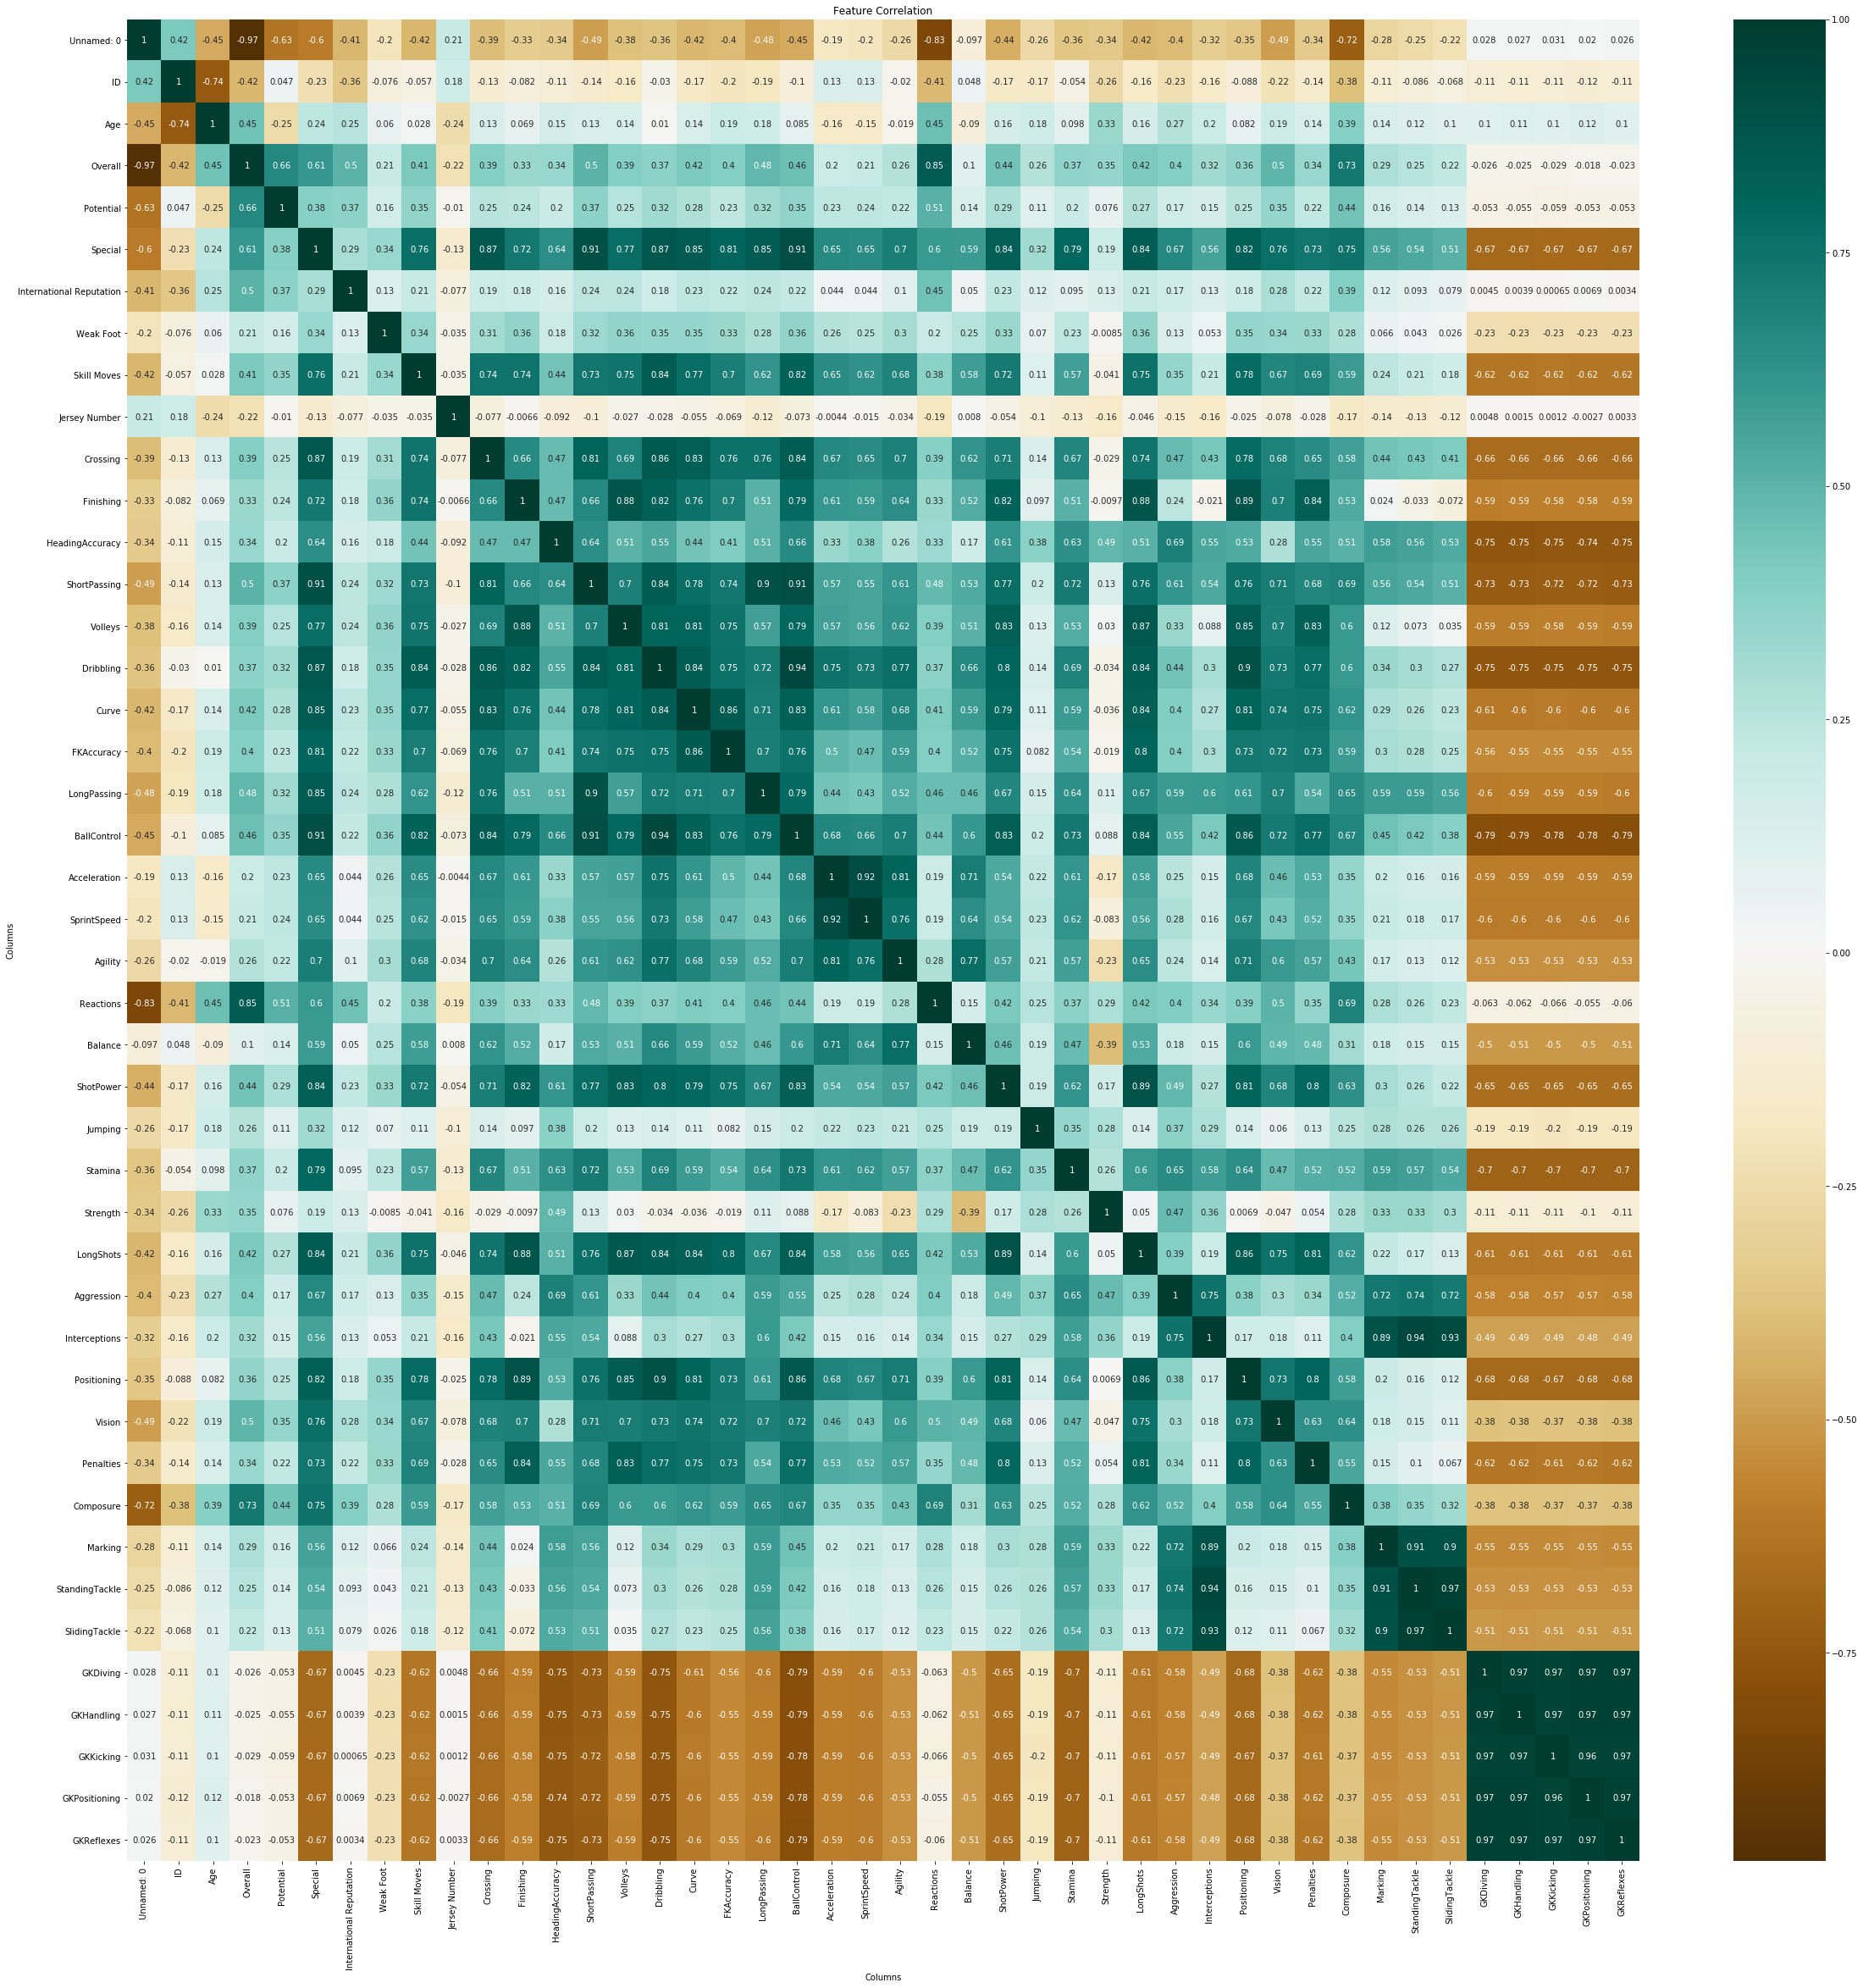

In [87]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(data.corr(), annot=True, ax=ax, cmap='BrBG').set(title='Feature Correlation', xlabel='Columns', ylabel='Columns')
plt.show()

## Extract World Club Rankings via Beautiful Soup

Later on we will use the world rankings of the soccer clubs to create a brand new feature for our main soccer player dataset, in case this novel additional feature may help the algorithm to sort out the players' relative importance within their segment (the term segment will be defined soon).

In [88]:
import requests
from bs4 import BeautifulSoup

In [89]:
data_club_rankings = pd.DataFrame(columns=['ranking', 'club', 'country', 'points'])

In [7]:


club_data = 4*[None]

for page_id in range(1,53):
    link = 'https://footballdatabase.com/ranking/world/'+str(page_id)
    print(link)
    result = requests.get(link)
    
    src = result.content
    soup = BeautifulSoup(src, 'lxml')

    content_rank = soup.find_all('td', attrs={'class':'rank'})
    content_club_text_left = soup.find_all('td', attrs={'class':'club text-left'})

    for i, e in enumerate(content_club_text_left):
        club_data[0] = content_rank[i*2].text
        club_data[1] = e.find_all('a')[0].text
        club_data[2] = e.find_all('a')[1].text
        club_data[3] = content_rank[i*2+1].text
        data_club_rankings.loc[data_club_rankings.shape[0]] = club_data
        #print("ranking: {}  Club: {}  Country: {}  Points: {}".format(club_data[0], club_data[1], club_data[2], club_data[3]))
        print("{}".format(club_data[1]))


extracting and scraping data from https://footballdatabase.com/ranking/world/


In [91]:
len(data.Club.unique())

652

In [92]:
data_club_rankings.head()

,ranking,club,country,points
0,1,Bayern München,Germany,2052
1,2,Liverpool FC,England,2013
2,3,Manchester City,England,1958
3,4,Barcelona,Spain,1947
4,5,Paris Saint-Germain,France,1927


### Matching Club Data

In [93]:
# from data to data_club_rankings
dict_club = {}
u_clubs = data.Club.unique()
ranked_clubs = list(data_club_rankings.club)
clubs_not_found = []

# u_club in data,  club in ranked_clubs
for u_club in u_clubs:
    if u_club not in list(ranked_clubs):
        is_found=False
        for club in ranked_clubs:
            condition_A = str(club) in str(u_club)
            condition_B = str(u_club) in str(club)
            if condition_A or condition_B:
                is_found = True
                dict_club[u_club] = club
                ranked_clubs.remove(club)
                break
        if not is_found:
            # check longest
            is_lengest_word_contained = False
            words_in_u_club = u_club.split(' ')
            len_words = [len(n) for n in words_in_u_club]
            np_list_len_words_in_u_club = np.array(len_words)
            longest_word_in_u_club = words_in_u_club[np_list_len_words_in_u_club.argmax()]
            for club in ranked_clubs:
                if longest_word_in_u_club in club:
                    dict_club[u_club] = club
                    ranked_clubs.remove(club)
                    is_lengest_word_contained = True
                    break
            if not is_lengest_word_contained:
                clubs_not_found.append(u_club)
    else:
        dict_club[u_club] = u_club
        ranked_clubs.remove(u_club)

In [6]:
clubs_not_found[:5]

['Tianjin Quanjian FC',
'Hebei China Fortune FC',
'Internacional',
'Stade Rennais FC',
'Olympiacos CFP']


In [8]:
dict_club

{'FC Barcelona': 'Barcelona',
 'Juventus': 'Juventus',
 'Paris Saint-Germain': 'Paris Saint-Germain',
 'Manchester United': 'Manchester United',
 'Manchester City': 'Manchester City',
 'Chelsea': 'Chelsea FC',
 'Real Madrid': 'Real Madrid',
 ...
}


### Manual Correction of Some Wrong Records

In [96]:
data_club_rankings[data_club_rankings.club.str.lower().str.contains('bren')]
#data_club_rankings[data_club_rankings.country=='France']

,ranking,club,country,points
2501,2502,Gradina Srebrenik,Bosnia and Herzegovina,1196


In [97]:
# correction on dictionary
dict_club[None] = 'unknown'
dict_club['Bayer 04 Leverkusen'] = 'Bayer Leverkusen'
dict_club['PFC CSKA Moscow'] = 'CSKA Moskva'
dict_club['Tigres U.A.N.L.'] = 'Tigres UANL'
dict_club['Derby County'] = 'Ross County'
dict_club['Club Atlético Talleres'] = 'Talleres de Cordoba'
dict_club['Ceará Sporting Club'] = 'Ceará SC'
dict_club['Rionegro Águilas'] = 'Águilas Doradas'
dict_club['América de Cali'] = 'América de Cali'
dict_club['Central Coast Mariners'] = 'Central Coast Mariners FC'
dict_club['US Orléans Loiret Football'] = 'unknown'
dict_club['Jaguares de Córdoba'] = 'CD Jaguares'
dict_club['Oldham Athletic'] = 'unknown'
dict_club['Notts County'] = 'unknown'
dict_club['Port Vale'] = 'unknown'
dict_club['Forest Green Rovers'] = 'unknown'
dict_club['Inter'] = 'Inter Milan'
dict_club['Internacional'] = 'Internacional'

In [98]:
# adding 'unknown' record to 'data_club_rankings' data frame
club_data = [data_club_rankings.shape[0], 'unknown', 'unknown', int(data_club_rankings.points.min())-20]
data_club_rankings.loc[data_club_rankings.shape[0]] = club_data

## Feature Creation

### Binning of The Ranked Soccer Clubs

- The clubs will be distributed into different buckets(categories) based on their points, from 14 to 1.
- The higher the bucket no is the the successful the clubs within are.
- The capacity of the buckets increases by 1.42 times for each number, so that the better clubs will be in narrower buckets and the unsuccessful clubs will be assigned to geometrically larger buckets relatively.

In [99]:
starting_position_for_cr_bin = 0
cr_bin_size = 10
extension_factor = 1.42
bin_no = 0
for i in range(data_club_rankings.shape[0]):
    if i == data_club_rankings.shape[0]-1:
        data_club_rankings.at[i, 'segment_point'] = bin_no+1
        break
    if i < starting_position_for_cr_bin + cr_bin_size:
        data_club_rankings.at[i, 'segment_point'] = bin_no
    elif i == starting_position_for_cr_bin + cr_bin_size:
        starting_position_for_cr_bin = i
        cr_bin_size = int(cr_bin_size * extension_factor)
        bin_no += 1
        data_club_rankings.at[i, 'segment_point'] = bin_no

for i in range(data_club_rankings.shape[0]):
    data_club_rankings.at[i, 'segment_point'] = data_club_rankings.segment_point.max() - data_club_rankings.segment_point[i]

In [100]:
data_club_rankings.head()

,ranking,club,country,points,segment_point
0,1,Bayern München,Germany,2052,14.0
1,2,Liverpool FC,England,2013,14.0
2,3,Manchester City,England,1958,14.0
3,4,Barcelona,Spain,1947,14.0
4,5,Paris Saint-Germain,France,1927,14.0


In [101]:
list(data_club_rankings[data_club_rankings.club == 'Inter Milan'].country)[0]

'Italy'

In [2]:
for i in range(data.shape[0]):
    match_in_ranked_clubs_df = 'unknown'
    if data.Club[i] in dict_club:
        match_in_ranked_clubs_df = dict_club[data.Club[i]]
    print("club: {},  match_in_ranked_clubs_df: {}".format(data.Club[i], match_in_ranked_clubs_df))
    cr_segment_point = list(data_club_rankings[data_club_rankings.club == match_in_ranked_clubs_df].segment_point)[0]
    cr_country = list(data_club_rankings[data_club_rankings.club == match_in_ranked_clubs_df].country)[0]
    #print("club: {},  match_in_ranked_clubs_df: {},  cr_segment_point: {},  cr_country: {}".format(data.Club[i], match_in_ranked_clubs_df, cr_segment_point, cr_country))
    data.at[i, 'club_segment_point'] = cr_segment_point
    data.at[i, 'club_country'] = cr_country
    

Maching club names from 2 different source...


In [103]:
data.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,club_segment_point,club_country
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M,14.0,Spain
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M,14.0,Italy
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M,14.0,France
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M,13.0,England
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M,14.0,England


### Now, let's derive our prospective target feature 'national_player'.
- Our brand new feature named 'national_player' will be assigned as 1, if the player played at least 1 international match in his national team and otherwise as 0.

In [104]:
data_fm['national_player'] = data_fm['IntCaps'].map(lambda x: 1 if x>0 else 0)

# Missing Value Treatment

### An overview on null and possible problematic values/features

In [105]:
data['Preferred Foot'].mode()

0    Right
dtype: object

In [106]:
#First let's drop evidently irrelevant features
columns_to_be_dropped = ['Joined', 'Real Face', 'Photo', 'Flag', 'Club Logo']
data = data.drop(columns_to_be_dropped, axis=1)

In [107]:
number_of_columns_with_null_values = len(data.isnull().any()[data.isnull().any()==True])
number_of_all_columns = len(data.columns)

print("{0} features have null values out of total {1} columns.".format(number_of_columns_with_null_values, number_of_all_columns))

74 features have null values out of total 86 columns.


### Null Value Percentage By Feature

In [108]:
(data.isnull().sum() / data.shape[0])[data.isnull().sum() / data.shape[0] > 0][:35]

Club                        0.013237
Preferred Foot              0.002636
International Reputation    0.002636
Weak Foot                   0.002636
Skill Moves                 0.002636
Work Rate                   0.002636
Body Type                   0.002636
Position                    0.003295
Jersey Number               0.003295
Loaned From                 0.930576
Contract Valid Until        0.015873
Height                      0.002636
Weight                      0.002636
LS                          0.114516
ST                          0.114516
RS                          0.114516
LW                          0.114516
LF                          0.114516
CF                          0.114516
RF                          0.114516
RW                          0.114516
LAM                         0.114516
CAM                         0.114516
RAM                         0.114516
LM                          0.114516
LCM                         0.114516
CM                          0.114516
R

In [109]:
(data.isnull().sum() / data.shape[0])[data.isnull().sum() / data.shape[0] > 0][35:]

LCB                0.114516
CB                 0.114516
RCB                0.114516
RB                 0.114516
Crossing           0.002636
Finishing          0.002636
HeadingAccuracy    0.002636
ShortPassing       0.002636
Volleys            0.002636
Dribbling          0.002636
Curve              0.002636
FKAccuracy         0.002636
LongPassing        0.002636
BallControl        0.002636
Acceleration       0.002636
SprintSpeed        0.002636
Agility            0.002636
Reactions          0.002636
Balance            0.002636
ShotPower          0.002636
Jumping            0.002636
Stamina            0.002636
Strength           0.002636
LongShots          0.002636
Aggression         0.002636
Interceptions      0.002636
Positioning        0.002636
Vision             0.002636
Penalties          0.002636
Composure          0.002636
Marking            0.002636
StandingTackle     0.002636
SlidingTackle      0.002636
GKDiving           0.002636
GKHandling         0.002636
GKKicking          0

# A typical unstructured dataset with lots of null and missing values

- so let's get started to mend them all, feature by feature.

In [110]:
data['Height']

0         5'7
1         6'2
2         5'9
3         6'4
4        5'11
         ... 
18202     5'9
18203     6'3
18204     5'8
18205    5'10
18206    5'10
Name: Height, Length: 18207, dtype: object

In [111]:
data['ST'].mode()

0    61+2
dtype: object

## Handling Missing Data

### Special Cases

- remove € sign and convert into numeric value K 1000 and M 1.000.000
- remove lbs expression from weight
- remove ' and convert numeric (1 foot == 12 inches)
- remove + sign and sum up both Operand

In [112]:
# remove € sign and convert into numeric value K 1000 and M 1.000.000
data['Release Clause'].fillna(value='€0.0K', inplace=True)
data['Wage'].fillna(value='€0.0K', inplace=True)
def convert_release_clause_into_numeric(x):
    x = str(x).replace('€', '')
    if 'M' in x:
        x = x.replace('M', '')
        x = float(x) * 1000000
    elif 'K' in x:
        x = x.replace('K', '')
        x = float(x) * 1000
    return x

monetary_features = ['Release Clause', 'Value', 'Wage']
for col in monetary_features:
    data[col] = data[col].map(convert_release_clause_into_numeric)
    data[col] = pd.to_numeric(data[col])

from numpy import nanmean
data['Value'] = data['Value'].apply(lambda x: nanmean(data.groupby('Club')['Value']) if x == None else x)



In [113]:
data.dtypes[:10]

Unnamed: 0       int64
ID               int64
Name            object
Age              int64
Nationality     object
Overall          int64
Potential        int64
Club            object
Value          float64
Wage           float64
dtype: object

In [114]:
# remove lbs expression from weight
def remove_lbs(x):
    x = str(x).replace('lbs', '')
    return x

data['Weight'] = data['Weight'].map(remove_lbs)
data['Weight'].mode()

0    165
dtype: object

In [115]:
# remove ' and convert numeric 
# Note: 1 foot height is equal to 12 inches
data['Height'].mode()
def convert_height_into_numeric(x):
    integer_part = float(str(x).split('\'')[0])
    float_part = 0.0
    if len(str(x).split('\'')) > 1:
        float_part = float(str(x).split('\'')[1])/12.0
    return integer_part + float_part

data['Height'] = data['Height'].map(convert_height_into_numeric)

In [116]:
#remove + sign and sum up both Operand
malformed_columns_with_plus_sign = [ 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 
                                    'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB' ]
def remove_plus(x):
    if '+' in str(x):
        x0 = float(str(x).split('+')[0])
        x1 = float(str(x).split('+')[1])
        return x0+x1
    return float(x)
for col in malformed_columns_with_plus_sign:
    data[col] = data[col].map(remove_plus)

data['ST'].mode()

0    63.0
dtype: float64

### Filling NA values

In [117]:
missing_columns_to_be_assigned_median = [ 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'LS', 'ST', 'RS', 'LW', 'LF',
       'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 
       'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB',
       'Height', 'Weight', 'International Reputation' ]


for col in missing_columns_to_be_assigned_median:
    data[col].fillna(value=data[col].median(), inplace=True)

#### Since the following features are rather characteristic than comparable quantitative values, assigning the median will be meaningless, it is much more accurate to consider them as the most common (mode) value.

In [118]:
missing_columns_to_be_assigned_mode = ['Body Type', 'Contract Valid Until', 'Weak Foot', 
                                       'Jersey Number', 'Preferred Foot', 'Skill Moves', 'Work Rate']

for col in missing_columns_to_be_assigned_mode:
    data[col].fillna(value=data[col].mode()[0], inplace=True)

Flagging them as 'unknown' might be better and may even indicate a common ground between them. Esspecially for club names ('Loaned From', 'Club').

In [119]:
data['Loaned From'].value_counts()

Atalanta                  20
Sassuolo                  18
SL Benfica                17
Juventus                  17
Sporting CP               14
                          ..
Scunthorpe United          1
FC Basel 1893              1
SSV Jahn Regensburg        1
Northampton Town           1
Central Coast Mariners     1
Name: Loaned From, Length: 341, dtype: int64

In [120]:
missing_columns_to_be_assigned_unknown = ['Loaned From', 'Position', 'Club']


for col in missing_columns_to_be_assigned_unknown:
    data[col].fillna(value='unknown', inplace=True)

In [121]:
data.head()

,Unnamed: 0,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,...,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,club_segment_point,club_country
0,0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,...,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,14.0,Spain
1,1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,...,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,14.0,Italy
2,2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,...,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,14.0,France
3,3,193080,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,...,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,13.0,England
4,4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,...,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,14.0,England


## Let's investigate our data

In [123]:
data.dtypes[:10]

Unnamed: 0       int64
ID               int64
Name            object
Age              int64
Nationality     object
Overall          int64
Potential        int64
Club            object
Value          float64
Wage           float64
dtype: object

In [124]:
data[data.Value>5000000].groupby(['Nationality'])['ID'].count()['United States']

11

### World Heat Map Stats By Country via Folium

Let's generate a heat map and reflect it onto the world map that describes the distrubution of player analytics in terms of different aspects.

In [26]:
data_heat = data[['Nationality', 'ID', 'Value']]
#data_heat['player_count_by_country'] = 

dict_country_name_from_df_to_follium = {}
dict_country_name_from_df_to_follium['United States'] = 'United States of America'
dict_country_name_from_df_to_follium['China PR'] = 'China'
dict_country_name_from_df_to_follium['Korea Republic'] = 'South Korea'
dict_country_name_from_df_to_follium['Korea DPR'] = 'North Korea'
dict_country_name_from_df_to_follium['Bosnia Herzegovina'] = 'Bosnia and Herzegovina'
dict_country_name_from_df_to_follium['FYR Macedonia'] = 'Macedonia'
dict_country_name_from_df_to_follium['Central African Rep.'] = 'Central African Republic'
dict_country_name_from_df_to_follium['Trinidad & Tobago'] = 'Trinidad and Tobago'
dict_country_name_from_df_to_follium['DR Congo'] = 'Democratic Republic of the Congo'
dict_country_name_from_df_to_follium['Congo'] = 'Republic of the Congo'
dict_country_name_from_df_to_follium['England'] = 'United Kingdom'
dict_country_name_from_df_to_follium['Republic of Ireland'] = 'Ireland'

data_heat.head(35)



series_player_counts = data_heat.groupby(['Nationality'])['ID'].count()
data_heat['Value'] = data_heat.Value.astype(float)

np_array_stats_by_country = np.hstack((np.array(series_player_counts.index), np.array(series_player_counts.values))).reshape(2,-1).T


data_heat = pd.DataFrame(np_array_stats_by_country, columns=['country', 'player_counts_by_country'])

data.Value = (data.Value).astype(float)
series_precious_players_by_country = data[data.Value>5000000].groupby(['Nationality'])['ID'].count()
series_precious_players_by_country

data.Overall = (data.Overall).astype(float)
series_average_overall_skill_of_players_by_country = data[data.national_player == 1].groupby(['Nationality'])['Overall'].mean()
series_average_overall_skill_of_players_by_country


# shrink data logarithmically to obtain a more representative distribution of values through different polars (coumtries)
data_heat['precious_player_counts_by_country'] = data_heat['country'].apply(lambda x: series_precious_players_by_country[x] if x in series_precious_players_by_country else 0)
data_heat['average_overall_skill_of_players_by_country'] = data_heat['country'].apply(lambda x: series_average_overall_skill_of_players_by_country[x] if x in series_average_overall_skill_of_players_by_country else 0)

print(data_heat.sort_values(by=['precious_player_counts_by_country'], ascending=False).head(6))

data_heat['precious_player_counts_by_country'] = data_heat['precious_player_counts_by_country'].apply(lambda x: math.log(x+1) if x+1!=0 else 0.0)
data_heat['average_overall_skill_of_players_by_country'] = data_heat['average_overall_skill_of_players_by_country'].apply(lambda x: x**2 if x>0 else x)

print(data_heat.sort_values(by=['average_overall_skill_of_players_by_country'], ascending=False).head(6))

data_heat['player_counts_by_country'] = data_heat['player_counts_by_country'].apply(lambda x: math.log(x) if x!=0 else 0.0)

# revise country names and modify if needed based on Folium API

data_heat['country'] = data_heat['country'].apply(lambda x: dict_country_name_from_df_to_follium[x] if x in dict_country_name_from_df_to_follium.keys() else x)


scaler = MinMaxScaler()
heat_columns = ['player_counts_by_country', 'precious_player_counts_by_country', 'average_overall_skill_of_players_by_country']

for col in heat_columns:
    data_heat[col] = scaler.fit_transform(np.array(data_heat[col]).reshape(-1, 1))

#data_heat['average_overall_skill_of_players_by_country'] = data_heat['average_overall_skill_of_players_by_country'].apply(lambda x: math.log(x+1) if x+1!=0 else 0.0)

print(data_heat.sort_values(by=['average_overall_skill_of_players_by_country'], ascending=False).head(6))


       country player_counts_by_country  precious_player_counts_by_country  \
139      Spain                     1072                                267   
20      Brazil                      827                                206   
55      France                      914                                185   
6    Argentina                      937                                147   
59     Germany                     1198                                139   
46     England                     1662                                121   

     average_overall_skill_of_players_by_country  
139                                    81.271186  
20                                     79.892857  
55                                     79.780000  
6                                      75.463918  
59                                     79.826923  
46                                     76.903226  
     country player_counts_by_country  precious_player_counts_by_country  \
139    Spain        

/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [126]:
data[data.Value>5000000].groupby(['Nationality'])['ID'].count().describe()

count    100.000000
mean      22.140000
std       44.849923
min        1.000000
25%        2.000000
50%        6.000000
75%       18.000000
max      267.000000
Name: ID, dtype: float64

### Player Counts by Country in 'data'

In [137]:
import folium

world_heat_map_player_count_by_country = folium.Map(
    location=[28.220860, 16.297040],
    #tiles='Stamen Terrain',
    zoom_start=1.5
)
#  One of the following color brewer palettes: 
# ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’

world_heat_map_player_count_by_country.choropleth(geo_data=world_countries_json_source, data=data_heat, columns=['country', 'player_counts_by_country'], key_on='feature.properties.name',
                         fill_color='OrRd', fill_opacity=0.7,  line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)

world_heat_map_player_count_by_country

/home/a/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Number of Precious Players by Country in 'data' (> $5,000,000)

- For Instance countries such as China, Saudi Arabia and New Zealand have large number of football players see the map above.      However the players from these countries do not have high market values as much. (see the map below)

- On the other hand, in Western Europe, players are high in number in the data frame 'data' and also top value players are widespread in this region as well.

In [146]:
world_heat_map_player_average_market_value_by_country = folium.Map(
    location=[28.220860, 16.297040],
    #tiles='Stamen Terrain',
    zoom_start=1.5
)
#  One of the following color brewer palettes: 
# ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’

world_heat_map_player_average_market_value_by_country.choropleth(geo_data=world_countries_json_source, data=data_heat, columns=['country', 'precious_player_counts_by_country'], key_on='feature.properties.name',
                         fill_color='OrRd', fill_opacity=0.7,  line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)

world_heat_map_player_average_market_value_by_country

In [147]:
data.head()

,Unnamed: 0,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,...,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,club_segment_point,club_country
0,0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,...,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,14.0,Spain
1,1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,...,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,14.0,Italy
2,2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,...,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,14.0,France
3,3,193080,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,...,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,13.0,England
4,4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,...,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,14.0,England


In [148]:
data.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Nationality', 'Overall',
       'Potential', 'Club', 'Value', 'Wage', 'Special', 'Preferred Foot',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate',
       'Body Type', 'Position', 'Jersey Number', 'Loaned From',
       'Contract Valid Until', 'Height', 'Weight', 'LS', 'ST', 'RS', 'LW',
       'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM',
       'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPos

In [149]:
data.Value

0        110500000.0
1         77000000.0
2        118500000.0
3         72000000.0
4        102000000.0
            ...     
18202        60000.0
18203        60000.0
18204        60000.0
18205        60000.0
18206        60000.0
Name: Value, Length: 18207, dtype: float64

In [150]:
data.shape

(18207, 86)

## Match players in Fifa 19 dataset with the ones in Football Manager 2017 in order to retrieve national_player feature
To Achieve this we need additional info such as age and nationality since only names may resemble between players and create conflict.

### Match Nationality And NationID
- The data frame 'data' has a string feature named 'Nationality', wgile data frame 'data_fm' has a numeric feature named 'NationID'
- For this reason, we should first match 'Nationality' and 'NationID' features.

In [152]:
nationalities_in_fifa19 = len(data.Nationality.unique())
nationalities_in_fm = len(data_fm.NationID.unique())
print("nationalities_in_fifa19: {0}\nnationalities_in_fm: {1}".format(nationalities_in_fifa19, nationalities_in_fm))

nationalities_in_fifa19: 164
nationalities_in_fm: 213


In [153]:
nationality_distribution_fifa = data.Nationality.value_counts()
sum_nat_55_plus = sum(nationality_distribution_fifa[nationality_distribution_fifa>55])
no_nat_55_plus = len(nationality_distribution_fifa[nationality_distribution_fifa>55])
total_players = len(data.ID.unique())
print("The number of nationalities with more than 55 players are {0} and covers {1} players out of {2}".format(no_nat_55_plus, sum_nat_55_plus, total_players))

The number of nationalities with more than 55 players are 50 and covers 16834 players out of 18207


So we will only define 50 natinalities and their corresponding NationIDs due to limited time. Still it will cover ~ %92.5 of the total players.

In [154]:
# find the players with similar names and obtain player's full name
def find_str(x, name):
    if name in x:
        print(x)
    return x
a = data_fm['Name'].apply(find_str, name='De Bruyne')

Kevin De Bruyne


In [155]:
data[data['Name'].str.contains('De Bruyne')]

,Unnamed: 0,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,...,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,club_segment_point,club_country
4,4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,...,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,14.0,England


In [156]:
# to display the player to obtain his NationID
#data_fm[data_fm['Name'] == 'Zhiyi']
data_fm[data_fm['Name'].str.contains('De Bruyne')]

,UID,Name,NationID,Born,Age,IntCaps,IntGoals,U21Caps,U21Goals,Height,...,DefenderCentral,DefenderLeft,DefenderRight,DefensiveMidfielder,MidfielderCentral,MidfielderLeft,MidfielderRight,WingBackLeft,WingBackRight,national_player
27787,18004457,Kevin De Bruyne,757,28-06-1991,25,45,12,2,0,181,...,1,1,1,12,18,18,18,1,1,1


#### Thus, 'NationID' 757 corresponds to the 'Nationality' Belgium

##### Let's start to build up our nationality dictionary with 50 nations

In [157]:
dict_nationality = {}
dict_nationality[788] = 'Portugal'
dict_nationality[1649] = 'Argentina'
dict_nationality[1651] = 'Brazil'
dict_nationality[796] = 'Spain'
dict_nationality[757] = 'Belgium'
dict_nationality[761] = 'Croatia'
dict_nationality[795] = 'Slovenia'
dict_nationality[787] = 'Poland'
dict_nationality[771] = 'Germany'
dict_nationality[1657] = 'Uruguay'
dict_nationality[769] = 'France'
dict_nationality[776] = 'Italy'
dict_nationality[16] = 'Egypt'
dict_nationality[764] = 'Denmark'
dict_nationality[19] = 'Gabon'
dict_nationality[801] = 'Wales'
dict_nationality[41] = 'Senegal'
dict_nationality[366] = 'Costa Rica'
dict_nationality[794] = 'Slovakia'
dict_nationality[784] = 'Netherlands'
dict_nationality[765] = 'England'
dict_nationality[759] = 'Bosnia Herzegovina'
dict_nationality[34] = 'Morocco'
dict_nationality[802] = 'Serbia'
dict_nationality[5] = 'Algeria'
dict_nationality[755] = 'Austria'
dict_nationality[772] = 'Greece'
dict_nationality[1652] = 'Chile'
dict_nationality[797] = 'Sweden'
dict_nationality[135] = 'Korea Republic'
dict_nationality[1653] = 'Colombia'
dict_nationality[22] = 'Guinea'
dict_nationality[379] = 'Mexico'
dict_nationality[11] = 'Cameroon'
dict_nationality[31] = 'Mali'
dict_nationality[799] = 'Turkey'
dict_nationality[1435] = 'Australia'
dict_nationality[24] = 'Ivory Coast'
dict_nationality[793] = 'Scotland'
dict_nationality[53] = 'DR Congo'
dict_nationality[1651] = 'Japan'
dict_nationality[110] = 'China PR'
dict_nationality[376] = 'Honduras'
dict_nationality[791] = 'Russia'
dict_nationality[789] = 'Republic of Ireland'
dict_nationality[390] = 'United States'
dict_nationality[786] = 'Norway'
dict_nationality[133] = 'Saudi Arabia'
dict_nationality[798] = 'Switzerland'
dict_nationality[21] = 'Ghana'


dict_nationality

{788: 'Portugal',
 1649: 'Argentina',
 1651: 'Japan',
 796: 'Spain',
 757: 'Belgium',
 761: 'Croatia',
 795: 'Slovenia',
 787: 'Poland',
 771: 'Germany',
 1657: 'Uruguay',
 769: 'France',
 776: 'Italy',
 16: 'Egypt',
 764: 'Denmark',
 19: 'Gabon',
 801: 'Wales',
 41: 'Senegal',
 366: 'Costa Rica',
 794: 'Slovakia',
 784: 'Netherlands',
 765: 'England',
 759: 'Bosnia Herzegovina',
 34: 'Morocco',
 802: 'Serbia',
 5: 'Algeria',
 755: 'Austria',
 772: 'Greece',
 1652: 'Chile',
 797: 'Sweden',
 135: 'Korea Republic',
 1653: 'Colombia',
 22: 'Guinea',
 379: 'Mexico',
 11: 'Cameroon',
 31: 'Mali',
 799: 'Turkey',
 1435: 'Australia',
 24: 'Ivory Coast',
 793: 'Scotland',
 53: 'DR Congo',
 110: 'China PR',
 376: 'Honduras',
 791: 'Russia',
 789: 'Republic of Ireland',
 390: 'United States',
 786: 'Norway',
 133: 'Saudi Arabia',
 798: 'Switzerland',
 21: 'Ghana'}

In [158]:
data['UID'] = data.shape[0] * [-1]
data['national_player'] = data.shape[0] * [None]

In [160]:
data.head()

,Unnamed: 0,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,...,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,club_segment_point,club_country,UID,national_player
0,0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,...,6.0,11.0,15.0,14.0,8.0,226500000.0,14.0,Spain,-1,None
1,1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,...,7.0,11.0,15.0,14.0,11.0,127100000.0,14.0,Italy,-1,None
2,2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,...,9.0,9.0,15.0,15.0,11.0,228100000.0,14.0,France,-1,None
3,3,193080,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,...,90.0,85.0,87.0,88.0,94.0,138600000.0,13.0,England,-1,None
4,4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,...,15.0,13.0,5.0,10.0,13.0,196400000.0,14.0,England,-1,None


### match players from 2 datasets

- The match_players_from_2_datasets function will match players from data frame 'data' with the data frame 'data_fm' based on their full name, age and nationality info (if exists).
- Subsequently, we will copy 'national_player' and 'UID' features from 'data_fm' to 'data'.

In [1]:


def match_players_from_2_datasets(row):
    fname = row['Name'].replace('ć', 'c').replace('č', 'c').replace('š', 's').replace('í', 'i')
    elm = fname.split(' ')
    length_checker = np.vectorize(len) 
    lenelm = length_checker(elm)
    shortest_word_in_name = elm[np.where(lenelm == lenelm.min())[0][0]]
    wanted_name = ''
    initial = ''
    
    
    if len(shortest_word_in_name)==2 and shortest_word_in_name[1]=='.':
        initial = shortest_word_in_name[0]
    
    
    if len(elm) > 1 and len(shortest_word_in_name)<3:
        wanted_name = fname.replace(shortest_word_in_name,'',1)
    else:
        wanted_name = fname
    
    #trims the white space at the start and end
    wanted_name = wanted_name.strip()
    
    
    print("{0}  >>>  wanted_name: {1}. {2}, row.Age: {3}".format(row['Unnamed: 0'], initial, wanted_name, row.Age))
    
    
    if wanted_name == '':
        return row
    
    
    cond_a = (data_fm.Name.str.contains(wanted_name))
    
    cond_b = data_fm.shape[0] * [True]
    
    if (initial!=''):
        cond_b = np.array(data_fm.Name.apply(lambda x: str(x).upper())).astype('<U1') == initial
    cond_c = (abs(row['Age']-data_fm.Age-2) < 2)
    
    nationality_contains_list = data_fm.NationID.apply(lambda x: True if x in dict_nationality.keys() and dict_nationality[x] == row['Nationality'] else False)
    
    cond_d = data_fm.shape[0] * [True]
    if row['Nationality'] in dict_nationality.values():
        cond_d = nationality_contains_list
    
    
    condition = cond_a & cond_b & cond_c & cond_d
    
    cond_a = np.array(cond_a, dtype=np.float64)
    cond_b = np.array(cond_b, dtype=np.float64)
    cond_c = np.array(cond_c, dtype=np.float64)
    
    cond_a_result = (cond_a.astype(float)).sum()
    cond_b_result = (cond_b.astype(float)).sum()
    cond_c_result = (cond_c.astype(float)).sum()
    
    condition_result = (condition.astype(float)).sum()
    
    
    
    print("CONDITIONS  a: {0}, b: {1}, c: {2}, condition: {3}".format(cond_a_result, cond_b_result, cond_c_result, condition_result))
    
    result_collection = data_fm[condition]
    
    np_value = result_collection['national_player']
    if np_value.shape[0] == 1:
        row['national_player'] = np_value.iloc[0]
    uid_value = result_collection['UID']
    if uid_value.shape[0] == 1:
        row['UID'] = uid_value.iloc[0]
        print ("UID: {0},  national_player: {1}".format(uid_value.iloc[0], np_value.iloc[0]))
    else:
        print(uid_value.shape[0])
    
    return row

from pandarallel import pandarallel

initial_date_time = datetime.now()
print("initial_date_time: {0}\n\n\n\n".format(initial_date_time))



starttime = time()

data = data.parallel_apply(match_players_from_2_datasets, axis=1)


print('That took {} seconds'.format(time() - starttime))

matching players from 2 datasets


In [162]:
data.head()

,Unnamed: 0,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,...,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,club_segment_point,club_country,UID,national_player
0,0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,...,6.0,11.0,15.0,14.0,8.0,226500000.0,14.0,Spain,7458500,1.0
1,1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,...,7.0,11.0,15.0,14.0,11.0,127100000.0,14.0,Italy,735216,1.0
2,2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,...,9.0,9.0,15.0,15.0,11.0,228100000.0,14.0,France,19024412,1.0
3,3,193080,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,...,90.0,85.0,87.0,88.0,94.0,138600000.0,13.0,England,67030171,1.0
4,4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,...,15.0,13.0,5.0,10.0,13.0,196400000.0,14.0,England,18004457,1.0


In [163]:
(data.isnull().sum() / data.shape[0])[data.isnull().sum() / data.shape[0] > 0][:45]

national_player    0.307904
dtype: float64

### Checkpoint - 1

Save newly acquired datasets

In [164]:
data.to_csv(r'fifa19_processed.csv', index = False)

In [4]:
data = pd.read_csv('fifa19_processed.csv')

In [166]:
data.shape

(18207, 88)

In [167]:
data.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Nationality', 'Overall',
       'Potential', 'Club', 'Value', 'Wage', 'Special', 'Preferred Foot',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate',
       'Body Type', 'Position', 'Jersey Number', 'Loaned From',
       'Contract Valid Until', 'Height', 'Weight', 'LS', 'ST', 'RS', 'LW',
       'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM',
       'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPos

#### Since we do not know target value national_player for some instances, we will not able to utilize that portion of the data with null target values neither in training nor in test or validation. So let's better drop them.

In [168]:
data = data.dropna(subset=['national_player', 'UID'], how='any').reset_index()

In [169]:
data.shape

(12601, 89)

In [170]:
data = data.drop(['Unnamed: 0', 'ID', 'Name', 'UID'], axis=1)

In [171]:
data.shape

(12601, 85)

### Distribution of the target value
As you can see below, data instances in our data frame 'data_fm' are extremely imbalanced and are majorly players with no international caps. The data frame 'data' which is mainly obtained from Fifa 19 data is also imbalanced, although to a lesser extent.

We will handle later on this imbalance problem via up-sampling.

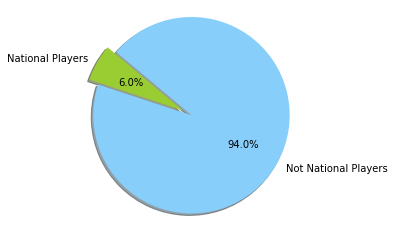

0    149905
1      9636
Name: national_player, dtype: int64

In [172]:
# data_fm
labels = 'National Players', 'Not National Players'
sizes = [data_fm.national_player.value_counts()[1], data_fm.national_player.value_counts()[0]]
colors = ['yellowgreen', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

data_fm.national_player.value_counts()

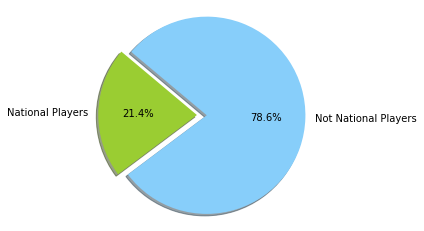

0.0    9909
1.0    2692
Name: national_player, dtype: int64

In [173]:

# data
labels = 'National Players', 'Not National Players'
sizes = [data.national_player.value_counts()[1], data.national_player.value_counts()[0]]
colors = ['yellowgreen', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

data.national_player.value_counts()

## Average Skill Value of National Players By Country

### Considering the following illustration, It is evident that the average skill level of the national players excessively varies from one country to another.
- 

In [27]:
import folium
world_heat_map_player_average_market_value_by_country = folium.Map(
    location=[28.220860, 16.297040],
    #tiles='Stamen Terrain',
    zoom_start=1.5
)
#  One of the following color brewer palettes: 
# ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’

world_heat_map_player_average_market_value_by_country.choropleth(geo_data=world_countries_json_source, data=data_heat, columns=['country', 'average_overall_skill_of_players_by_country'], key_on='feature.properties.name',
                         fill_color='OrRd', fill_opacity=0.7,  line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)

world_heat_map_player_average_market_value_by_country

/home/a/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Outlier Treatment

#### As you can see below, some players have astronomical market values in comparison to other more 'modest' players.
Even displaying players with market value more than $20 millions, there are outliers and extreme instances.
Same is valid for 'Wage' and 'Release Clause' features.

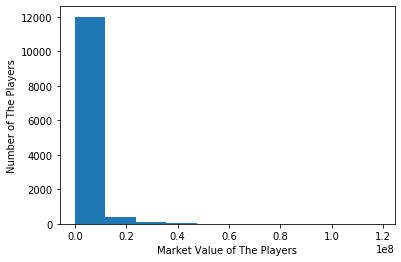

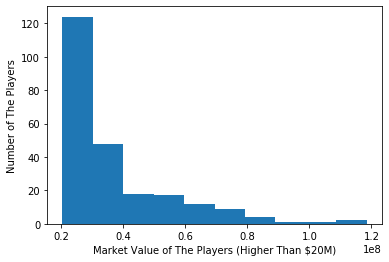

In [175]:
plt.hist(data['Value'])
plt.xlabel('Market Value of The Players')
plt.ylabel('Number of The Players')
plt.show()

plt.hist(data[data.Value > 20000000]['Value'])
plt.xlabel('Market Value of The Players (Higher Than $20M)')
plt.ylabel('Number of The Players')
plt.show()

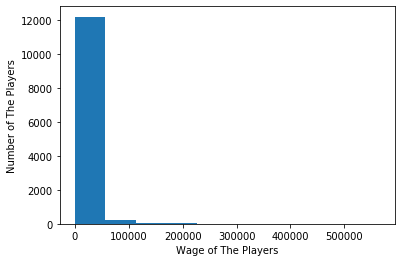

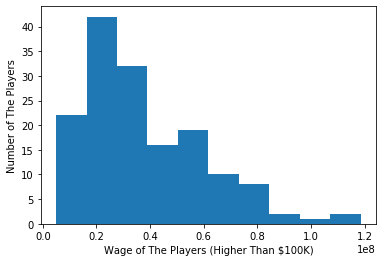

In [176]:
plt.hist(data['Wage'])
plt.xlabel('Wage of The Players')
plt.ylabel('Number of The Players')
plt.show()

plt.hist(data[data.Wage > 100000]['Value'])
plt.xlabel('Wage of The Players (Higher Than $100K)')
plt.ylabel('Number of The Players')
plt.show()

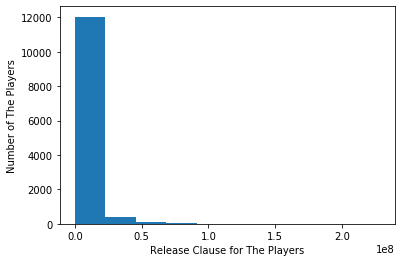

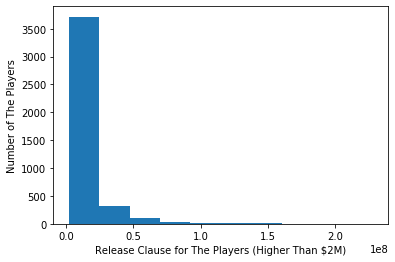

In [177]:
plt.hist(data['Release Clause'])
plt.xlabel('Release Clause for The Players')
plt.ylabel('Number of The Players')
plt.show()

plt.hist(data[data['Release Clause'] > 2000000]['Release Clause'])
plt.xlabel('Release Clause for The Players (Higher Than $2M)')
plt.ylabel('Number of The Players')
plt.show()

In [178]:
# Assign 0 market value and wages as the median of the series. 
# Because, 0 wage is unrealistic and may be misleading
numeric_columns_to_be_shrunk = ['Value', 'Wage']
for col in numeric_columns_to_be_shrunk:
    data[col] = data[col].apply(lambda x: data[col].median() if x==0.0 else x)

#### So we will shrink those features via logarithmic function in order to acquire a more meaningful set of values for the training.

In [179]:
numeric_columns_to_be_shrunk = ['Value', 'Wage', 'Release Clause']
for col in numeric_columns_to_be_shrunk:
    data[col+'_shrunk'] = data[col].apply(lambda x: math.log(x+0.01))

In [180]:
data = data.drop(numeric_columns_to_be_shrunk, axis=1)

In [181]:
data.head()

,index,Age,Nationality,Overall,Potential,Club,Special,Preferred Foot,International Reputation,Weak Foot,...,GKHandling,GKKicking,GKPositioning,GKReflexes,club_segment_point,club_country,national_player,Value_shrunk,Wage_shrunk,Release Clause_shrunk
0,0,31,Argentina,94,94,FC Barcelona,2202,Left,5.0,4.0,...,11.0,15.0,14.0,8.0,14.0,Spain,1.0,18.520526,13.244581,19.238256
1,1,33,Portugal,94,94,Juventus,2228,Right,5.0,4.0,...,11.0,15.0,14.0,11.0,14.0,Italy,1.0,18.159316,12.911642,18.660485
2,2,26,Brazil,92,93,Paris Saint-Germain,2143,Right,5.0,5.0,...,9.0,15.0,15.0,11.0,14.0,France,1.0,18.590424,12.577636,19.245295
3,3,27,Spain,91,93,Manchester United,1471,Right,4.0,3.0,...,85.0,87.0,88.0,94.0,13.0,England,1.0,18.092177,12.468437,18.747103
4,4,27,Belgium,91,92,Manchester City,2281,Right,4.0,5.0,...,13.0,5.0,10.0,13.0,14.0,England,1.0,18.440483,12.779873,19.095664


#### Shrunk Feature Histograms

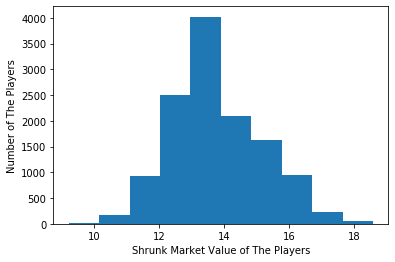

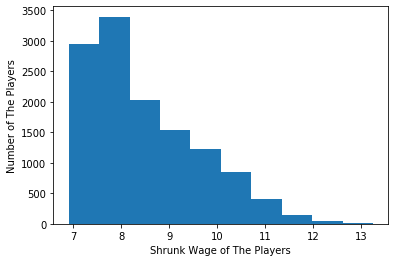

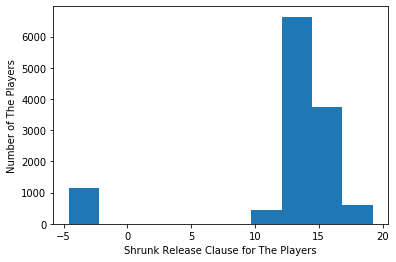

In [183]:
plt.hist(data['Value_shrunk'])
plt.xlabel('Shrunk Market Value of The Players')
plt.ylabel('Number of The Players')
plt.show()

plt.hist(data['Wage_shrunk'])
plt.xlabel('Shrunk Wage of The Players')
plt.ylabel('Number of The Players')
plt.show()

plt.hist(data['Release Clause_shrunk'])
plt.xlabel('Shrunk Release Clause for The Players')
plt.ylabel('Number of The Players')
plt.show()

## More Feature Creation

### Creating positionID by utilizing following columns

In [185]:
position_columns = ['LS', 'ST', 'RS', 'LW',
           'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM',
           'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']

In [186]:
data[position_columns].head()

,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,...,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,90.0,90.0,90.0,94.0,95.0,95.0,95.0,94.0,95.0,95.0,...,66.0,63.0,63.0,63.0,66.0,61.0,49.0,49.0,49.0,61.0
1,94.0,94.0,94.0,92.0,93.0,93.0,93.0,92.0,91.0,91.0,...,68.0,64.0,64.0,64.0,68.0,64.0,56.0,56.0,56.0,64.0
2,87.0,87.0,87.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,...,68.0,63.0,63.0,63.0,68.0,63.0,50.0,50.0,50.0,63.0
3,60.0,60.0,60.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,...,60.0,60.0,60.0,60.0,60.0,60.0,59.0,59.0,59.0,60.0
4,85.0,85.0,85.0,90.0,90.0,90.0,90.0,90.0,91.0,91.0,...,80.0,80.0,80.0,80.0,80.0,76.0,69.0,69.0,69.0,76.0


In [187]:
for col in position_columns:
    data[col] = data[col].apply(lambda x: x/100.0)

In [188]:
from sklearn.cluster import KMeans

X = np.array(data[position_columns])

kmeans = KMeans(n_clusters=11, random_state=0).fit(X)

for i in range(0, data.shape[0]):
    data.at[i, 'PositionID'] = kmeans.labels_[i]


In [189]:
data.head()

,index,Age,Nationality,Overall,Potential,Club,Special,Preferred Foot,International Reputation,Weak Foot,...,GKKicking,GKPositioning,GKReflexes,club_segment_point,club_country,national_player,Value_shrunk,Wage_shrunk,Release Clause_shrunk,PositionID
0,0,31,Argentina,94,94,FC Barcelona,2202,Left,5.0,4.0,...,15.0,14.0,8.0,14.0,Spain,1.0,18.520526,13.244581,19.238256,3.0
1,1,33,Portugal,94,94,Juventus,2228,Right,5.0,4.0,...,15.0,14.0,11.0,14.0,Italy,1.0,18.159316,12.911642,18.660485,3.0
2,2,26,Brazil,92,93,Paris Saint-Germain,2143,Right,5.0,5.0,...,15.0,15.0,11.0,14.0,France,1.0,18.590424,12.577636,19.245295,3.0
3,3,27,Spain,91,93,Manchester United,1471,Right,4.0,3.0,...,87.0,88.0,94.0,13.0,England,1.0,18.092177,12.468437,18.747103,10.0
4,4,27,Belgium,91,92,Manchester City,2281,Right,4.0,5.0,...,5.0,10.0,13.0,14.0,England,1.0,18.440483,12.779873,19.095664,8.0


#### newly created PositionID feature value distrubution

In [191]:
data.PositionID.value_counts()

10.0    2540
4.0     1535
1.0     1438
0.0     1435
5.0     1240
2.0      945
9.0      848
8.0      704
6.0      688
7.0      668
3.0      560
Name: PositionID, dtype: int64

### Here is the magical touch

## Creation of distance of each player's key features from his segment's mean, max and median
- A player has a value (market value), wage and release clause numeric features which we have already normalized and shrank.
- That features may indicate the player's importance to his national team.
- However, each national team has a different player profile at varying skills and importance. While Spain national team has plenty of talents, it is hard to say the same thing for Greenland. Two players with the resambling skills may be indispensible to a middling national team in their squad and may not be in even first 24 for another (top class national team).
- So the players' metrics should be investigated in the frame of their segment.
- In this work, segment refers to nationality and position in play of the player.

In [193]:
columns_for_segment_comparison = ['Value_shrunk', 'Wage_shrunk', 'Release Clause_shrunk']

for col in columns_for_segment_comparison:
    for i in range(0, data.shape[0]):
        data.at[i, 'DistanceToMaxInSegment_'+col] = data.at[i, col] - data[(data.Nationality == data.at[i, 'Nationality']) &  (data.PositionID == data.at[i, 'PositionID'])][col].max()
        data.at[i, 'DistanceToMedianInSegment_'+col] = data.at[i, col] - data[(data.Nationality == data.at[i, 'Nationality']) &  (data.PositionID == data.at[i, 'PositionID'])][col].median()

In [195]:
data = data.drop(['index'], axis=1)
data.tail()

,Age,Nationality,Overall,Potential,Club,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,...,Value_shrunk,Wage_shrunk,Release Clause_shrunk,PositionID,DistanceToMaxInSegment_Value_shrunk,DistanceToMedianInSegment_Value_shrunk,DistanceToMaxInSegment_Wage_shrunk,DistanceToMedianInSegment_Wage_shrunk,DistanceToMaxInSegment_Release Clause_shrunk,DistanceToMedianInSegment_Release Clause_shrunk
12596,18,England,47,67,Cambridge United,1285,Right,1.0,3.0,2.0,...,11.002100,6.907765,12.013701,7.0,-3.401197,-1.152679,-3.401188,-0.693142,-2.995732,-0.847298
12597,18,England,47,65,Cambridge United,1250,Left,1.0,3.0,2.0,...,10.819778,6.907765,11.686879,7.0,-3.583519,-1.335001,-3.401188,-0.693142,-3.322554,-1.174120
12598,18,England,47,64,Cambridge United,1325,Right,1.0,3.0,2.0,...,10.819778,6.907765,11.686879,7.0,-3.583519,-1.335001,-3.401188,-0.693142,-3.322554,-1.174120
12599,18,Scotland,47,62,Swindon Town,1203,Left,1.0,2.0,2.0,...,11.002100,6.907765,11.870600,6.0,-2.590267,-1.152679,-1.945902,0.000000,-2.586764,-0.963726
12600,19,England,47,65,Crewe Alexandra,1307,Right,1.0,2.0,2.0,...,11.002100,6.907765,11.870600,7.0,-3.401197,-1.152679,-3.401188,-0.693142,-3.138833,-0.990399


### Checkpoint - 2

Save current state of the dataset

In [196]:
data.to_csv(r'fifa19_processed2.csv', index = False)

In [29]:
data = pd.read_csv('fifa19_processed2.csv')

#### drop 'International Reputation' to avoid a potential data leakage

In [30]:
data = data.drop(['International Reputation'], axis=1)

In [31]:
data['Weight'].fillna(value=data['Weight'].median(), inplace=True)

### Another Feature Which may contribute to model training: number_of_national_players_by_nation

In [32]:
number_of_national_players_by_nation = data.groupby("Nationality").national_player.sum()
data['number_of_national_players_by_nation'] = data['Nationality'].apply(lambda x: number_of_national_players_by_nation[x])

In [33]:
data.head(3)

,Age,Nationality,Overall,Potential,Club,Special,Preferred Foot,Weak Foot,Skill Moves,Work Rate,...,Wage_shrunk,Release Clause_shrunk,PositionID,DistanceToMaxInSegment_Value_shrunk,DistanceToMedianInSegment_Value_shrunk,DistanceToMaxInSegment_Wage_shrunk,DistanceToMedianInSegment_Wage_shrunk,DistanceToMaxInSegment_Release Clause_shrunk,DistanceToMedianInSegment_Release Clause_shrunk,number_of_national_players_by_nation
0,31,Argentina,94,94,FC Barcelona,2202,Left,4.0,4.0,Medium/ Medium,...,13.244581,19.238256,3.0,0.0,2.507791,0.000000,3.158772,0.0,2.783688,97.0
1,33,Portugal,94,94,Juventus,2228,Right,4.0,5.0,High/ Low,...,12.911642,18.660485,3.0,0.0,1.862383,0.000000,3.200985,0.0,1.704215,49.0
2,26,Brazil,92,93,Paris Saint-Germain,2143,Right,5.0,5.0,High/ Medium,...,12.577636,19.245295,3.0,0.0,2.354792,-0.159065,2.451005,0.0,2.573909,28.0


## Normalization

### One Hot Encoder & MinMaxScaler

In [34]:
# gather non-numeric columns
non_numeric_columns = []
s = data.dtypes
for i in range(0, len(data.dtypes)):
    e = data.dtypes[i]
    if e!=float and e!=int:
        non_numeric_columns.append(s.index[i])

non_numeric_columns = non_numeric_columns + ['PositionID']
non_numeric_columns

['Nationality',
 'Club',
 'Preferred Foot',
 'Work Rate',
 'Body Type',
 'Position',
 'Loaned From',
 'Contract Valid Until',
 'club_country',
 'PositionID']

In [35]:
data['Loaned From'].value_counts()

unknown                   11642
Atalanta                     20
Sassuolo                     17
Juventus                     15
SL Benfica                   13
                          ...  
Lechia Gdańsk                 1
FC Nantes                     1
1. FC Köln                    1
Club Atlético Banfield        1
Club Atlético Tigre           1
Name: Loaned From, Length: 299, dtype: int64

In [36]:
data.iloc[70:76]

,Age,Nationality,Overall,Potential,Club,Special,Preferred Foot,Weak Foot,Skill Moves,Work Rate,...,Wage_shrunk,Release Clause_shrunk,PositionID,DistanceToMaxInSegment_Value_shrunk,DistanceToMedianInSegment_Value_shrunk,DistanceToMaxInSegment_Wage_shrunk,DistanceToMedianInSegment_Wage_shrunk,DistanceToMaxInSegment_Release Clause_shrunk,DistanceToMedianInSegment_Release Clause_shrunk,number_of_national_players_by_nation
70,23,Germany,85,88,FC Bayern München,2185,Right,4.0,3.0,High/ Low,...,11.429544,18.062576,8.0,-0.635989,1.398717,-1.350329,0.966849,-0.807905,1.367867,52.0
71,27,Algeria,85,85,Manchester City,2031,Left,4.0,5.0,Medium/ Medium,...,12.230765,18.131664,3.0,0.000000,1.477044,0.000000,1.767662,-0.040555,1.414732,32.0
72,26,Austria,85,87,FC Bayern München,2261,Left,4.0,3.0,High/ Medium,...,11.608236,17.999086,8.0,0.000000,1.590414,0.000000,1.168101,0.000000,1.578723,36.0
73,27,France,85,86,Arsenal,2060,Right,4.0,4.0,High/ High,...,12.100712,18.303023,3.0,-0.587787,1.609438,-0.287682,1.609438,-0.625078,1.634023,50.0
74,27,Greece,85,87,Roma,1642,Right,2.0,2.0,Low/ High,...,11.472104,18.014215,1.0,0.000000,3.847484,0.000000,2.954908,0.000000,3.610918,33.0
75,30,Argentina,85,85,Manchester City,1916,Right,3.0,2.0,High/ High,...,12.043554,17.780126,4.0,0.000000,2.356652,0.000000,2.938573,0.000000,2.833734,97.0


In [37]:
data = pd.get_dummies(data, columns=non_numeric_columns)

#### Scale data between 0.0 and 1.0 for each feature

In [38]:
scaler = MinMaxScaler()
for col in data.columns:
    data[col] = scaler.fit_transform(np.array(data[col]).reshape(-1, 1))

In [39]:
data.shape

(12601, 1300)

# Training The Model

### Split the data frame into 2 completely separate pieces, shuffle the rows and keep 2nd half for test

In [40]:

data_pos = data[data.national_player == 1.0]
data_neg = data[data.national_player == 0.0]

validation_spilt_ratio = 0.25

data_pos_0 = data_pos.sample(frac=validation_spilt_ratio)
data_pos_1 = data_pos.drop(data_pos_0.index)

data_neg_0 = data_neg.sample(frac=validation_spilt_ratio)
data_neg_1 = data_neg.drop(data_neg_0.index)

data_train = pd.concat([data_pos_1, data_neg_1], ignore_index=True)
data_train = data_train.sample(frac=1).reset_index(drop=True)
data_validation = pd.concat([data_pos_0, data_neg_0], ignore_index=True)
data_validation = data_validation.sample(frac=1).reset_index(drop=True)

In [41]:
data_validation.shape

(3150, 1300)

In [42]:

X = np.array(data_train.drop(['national_player'], 1)).astype(float)
y = np.array(data_train['national_player']).astype(float)

## Up-Sampling

In [43]:
def up_sample_minority_class(df, random_state, is_future_selection_to_be_made):
    # Entries of the both minority and majority classes
    data_majority = df.loc[df['national_player'] == 0.0]
    data_minority = df.loc[df['national_player'] == 1.0]
    
    print("data_majority: {0} @ data_minority: {1}".format(len(data_majority), len(data_minority)))
    
    #populates the minority portion of the samples up to the size of majority portion
    data_minority_up_sampled = resample(data_minority, 
                                     replace=True,
                                     n_samples=len(data_majority),
                                     random_state=random_state)
    
    # Combine majority class with upsampled minority class
    data_up_sampled = pd.concat([data_majority, data_minority_up_sampled])
    
    # Display new class counts
    print(data_up_sampled.national_player.value_counts())
    
    X_up_sampled = np.array(data_up_sampled.drop(['national_player'], 1).astype(float))
    y_up_sampled = np.array(data_up_sampled['national_player']).astype(float)
    
    if is_future_selection_to_be_made:
        X_up_sampled = SelectKBest(chi2, k=10).fit_transform(X_up_sampled, y_up_sampled)
    
    X_train_up_sampled, X_test_up_sampled, y_train_up_sampled, y_test_up_sampled = train_test_split(X_up_sampled, y_up_sampled, random_state=random_state)
    
    return X_train_up_sampled, X_test_up_sampled, y_train_up_sampled, y_test_up_sampled, X_up_sampled, y_up_sampled

In [44]:
#X = SelectKBest(chi2, k=40).fit_transform(X, y)

X_train, X_test, y_train, y_test, X, y = up_sample_minority_class(data_train, 28, False)
#train_test_split(X, y, test_size=0.25)

data_majority: 7432 @ data_minority: 2019
1.0    7432
0.0    7432
Name: national_player, dtype: int64


### Train model on training set and Display the Performance Matrics

In [45]:

# Tried Principal Component Analysis to make the calculations faster 
# and see if it improves the performance by any chance


# from sklearn.decomposition import PCA

# # feature extraction
# pca = PCA(n_components=X_train.shape[1]-0)
# fit = pca.fit(X_train)

# # # summarize components
# # #print("Explained Variance: %s" % fit.explained_variance_ratio_)
# # #print(fit.components_)

# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)





clf = RandomForestClassifier(max_depth=24, n_estimators=60, n_jobs=-2)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)


# threshold = 0.35

# prediction_probablities = clf.predict_proba(X_test)
# predictions = (prediction_probablities [:,1] >= threshold).astype('float')


print("\nAccuracy Score: {0}".format(accuracy_score(y_test, predictions)))
print("Precision Score: {0}".format(precision_score(y_test, predictions)))
print("Recall Score: {0}".format(recall_score(y_test, predictions)))
print("F-Beta Score: {0}".format(fbeta_score(y_test, predictions, beta=1.0)))


Accuracy Score: 0.9491388589881593
Precision Score: 0.925777331995988
Recall Score: 0.9782723900370959
F-Beta Score: 0.9513012110280855


## Validation

In [47]:

X_validation = np.array(data_validation.drop(['national_player'], 1)).astype(float)
y_validation = np.array(data_validation['national_player']).astype(float)


X_train_validation, X_test_validation, y_train_validation, y_test_validation, X_validation, y_validation = up_sample_minority_class(data_validation, 145, False)
#train_test_split(X_validation, y_validation, test_size=0.25)
#train_test_split(X, y, test_size=0.25)

# print("X_test_validation: "+str(X_test_validation.shape))


# X_test_validation = pca.transform(X_test_validation)

# print("X_test_validation: "+str(X_test_validation.shape))



predictions_validation = clf.predict(X_test_validation)


threshold = 0.33

prediction_probablities_validation = clf.predict_proba(X_test_validation)
predictions_validation = (prediction_probablities_validation [:,1] >= threshold).astype('float')


print("\nValidation Accuracy Score: {0}".format(accuracy_score(y_test_validation, predictions_validation)))
print("Validation Precision Score: {0}".format(precision_score(y_test_validation, predictions_validation)))
print("Validation Recall Score: {0}".format(recall_score(y_test_validation, predictions_validation)))
print("Validation F-Beta Score: {0}".format(fbeta_score(y_test_validation, predictions_validation, beta=2.0)))

data_majority: 2477 @ data_minority: 673
1.0    2477
0.0    2477
Name: national_player, dtype: int64

Validation Accuracy Score: 0.8393866020984665
Validation Precision Score: 0.7985185185185185
Validation Recall Score: 0.8953488372093024
Validation F-Beta Score: 0.8741485566007136


## Further Investigation False Prediction Distributions

In [48]:

prediction_probablities_validation = clf.predict_proba(X_test_validation)
predictions_validation = (prediction_probablities_validation [:,1] >= threshold).astype('float')


wrongly_predicted_sample_indices = []
for i in range(len(predictions_validation)):
    if predictions_validation[i] != y_test_validation[i]:
        wrongly_predicted_sample_indices.append(i)

len(wrongly_predicted_sample_indices)

199

In [49]:
data_y_test_validation = pd.DataFrame(data = y_test_validation[wrongly_predicted_sample_indices], columns = ['national_player']).reset_index()
data_X_test_validation = pd.DataFrame(data = X_test_validation[wrongly_predicted_sample_indices], columns = data.drop(['national_player'], axis = 1).columns).reset_index()
data_wrongly_predicted = pd.merge(data_X_test_validation, data_y_test_validation, how = 'left', left_index = True, right_index = True).drop(['index_x', 'index_y'], axis=1)

In [51]:
data_wrongly_predicted.head()

,Age,Overall,Potential,Special,Weak Foot,Skill Moves,Jersey Number,Height,Weight,LS,...,PositionID_2.0,PositionID_3.0,PositionID_4.0,PositionID_5.0,PositionID_6.0,PositionID_7.0,PositionID_8.0,PositionID_9.0,PositionID_10.0,national_player
0,0.357143,0.553191,0.553191,0.527604,0.50,0.25,0.010204,0.631579,0.495798,0.262295,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.392857,0.617021,0.595745,0.734003,0.50,0.75,0.091837,0.315789,0.201681,0.672131,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.571429,0.553191,0.531915,0.246550,0.50,0.00,0.000000,0.578947,0.554622,0.442623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.428571,0.425532,0.404255,0.620452,0.75,0.50,0.102041,0.473684,0.310924,0.491803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.250000,0.510638,0.702128,0.291092,0.50,0.00,0.112245,0.578947,0.478992,0.442623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [54]:
print("Age.mean for data_wrongly_predicted: {}, Age.mean for data_validation: {}"
      .format(data_wrongly_predicted.Age.mean(), data_validation.Age.mean()))

Age.mean for data_wrongly_predicted: 0.3962670495333812, Age.mean for data_validation: 0.33834467120181366


In [55]:
comparison_table = pd.DataFrame(None, columns = ['row_id'] + list(data.columns))

In [56]:
data_wrongly_predicted.name = 'data_wrongly_predicted'
data_validation.name = 'data_validation'


for df in [data_wrongly_predicted, data_validation]:
    s = df.mean()
    s['row_id'] = df.name + '.mean()'
    comparison_table = comparison_table.append(s, ignore_index=True)


for df in [data_wrongly_predicted, data_validation]:
    s = df.sum()
    s['row_id'] = df.name + '.sum()'
    comparison_table = comparison_table.append(s, ignore_index=True)

In [57]:
i = 4
comparison_table.iloc[:,i*20:(i+1)*20]

,DistanceToMedianInSegment_Release Clause_shrunk,number_of_national_players_by_nation,Nationality_Afghanistan,Nationality_Albania,Nationality_Algeria,Nationality_Andorra,Nationality_Angola,Nationality_Antigua & Barbuda,Nationality_Argentina,Nationality_Armenia,Nationality_Australia,Nationality_Austria,Nationality_Azerbaijan,Nationality_Barbados,Nationality_Belarus,Nationality_Belgium,Nationality_Belize,Nationality_Benin,Nationality_Bermuda,Nationality_Bolivia
0,0.473960,0.499042,0.000000,0.005025,0.000000,0.000000,0.000000,0.000000,0.060302,0.005025,0.005025,0.015075,0.0,0.0,0.0,0.035176,0.000000,0.000000,0.0,0.000000
1,0.478582,0.550355,0.000635,0.001587,0.002857,0.000317,0.000317,0.000635,0.051429,0.000317,0.014921,0.014286,0.0,0.0,0.0,0.020000,0.000317,0.000635,0.0,0.000317
2,94.318104,99.309278,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,1.000000,1.000000,3.000000,0.0,0.0,0.0,7.000000,0.000000,0.000000,0.0,0.000000
3,1507.533372,1733.618557,2.000000,5.000000,9.000000,1.000000,1.000000,2.000000,162.000000,1.000000,47.000000,45.000000,0.0,0.0,0.0,63.000000,1.000000,2.000000,0.0,1.000000


In [58]:

for col in comparison_table.columns:
    if col in ['row_id']:
        comparison_table.at[4, col] = 'wrong_ratio/all_ratio'
        comparison_table.at[5, col] = 'wrong_count/all_count'
    elif comparison_table.at[1, col] != 0.0 and comparison_table.at[3, col] != 0.0:
        comparison_table.at[4, col] = comparison_table.at[0, col] / comparison_table.at[1, col]
        comparison_table.at[5, col] = comparison_table.at[2, col] / comparison_table.at[3, col]
        

In [59]:
comparison_table[['row_id', 'number_of_national_players_by_nation']]

,row_id,number_of_national_players_by_nation
0,data_wrongly_predicted.mean(),0.499042
1,data_validation.mean(),0.550355
2,data_wrongly_predicted.sum(),99.309278
3,data_validation.sum(),1733.618557
4,wrong_ratio/all_ratio,0.906763
5,wrong_count/all_count,0.057284


### Let's create a comparison table for false predictions to better understand the variation and to detect potantial anomalies

In [61]:
comparison_table_T = comparison_table.T

In [62]:
comparison_table_T.head()

,0,1,2,3,4,5
row_id,data_wrongly_predicted.mean(),data_validation.mean(),data_wrongly_predicted.sum(),data_validation.sum(),wrong_ratio/all_ratio,wrong_count/all_count
Age,0.396267,0.338345,78.8571,1065.79,1.17119,0.0739897
Overall,0.493852,0.429706,98.2766,1353.57,1.14928,0.0726052
Potential,0.52133,0.50485,103.745,1590.28,1.03264,0.0652369
Special,0.589324,0.545587,117.275,1718.6,1.08016,0.068239


In [63]:
comparison_table_T.columns = list(np.array(comparison_table_T[:1]))[0]

In [64]:
comparison_table_T.shape

(1301, 6)

In [65]:
comparison_table_T.head()

,data_wrongly_predicted.mean(),data_validation.mean(),data_wrongly_predicted.sum(),data_validation.sum(),wrong_ratio/all_ratio,wrong_count/all_count
row_id,data_wrongly_predicted.mean(),data_validation.mean(),data_wrongly_predicted.sum(),data_validation.sum(),wrong_ratio/all_ratio,wrong_count/all_count
Age,0.396267,0.338345,78.8571,1065.79,1.17119,0.0739897
Overall,0.493852,0.429706,98.2766,1353.57,1.14928,0.0726052
Potential,0.52133,0.50485,103.745,1590.28,1.03264,0.0652369
Special,0.589324,0.545587,117.275,1718.6,1.08016,0.068239


In [66]:
comparison_table_T = comparison_table_T.drop(comparison_table_T.index[0])
comparison_table_T.head()

,data_wrongly_predicted.mean(),data_validation.mean(),data_wrongly_predicted.sum(),data_validation.sum(),wrong_ratio/all_ratio,wrong_count/all_count
Age,0.396267,0.338345,78.8571,1065.79,1.17119,0.0739897
Overall,0.493852,0.429706,98.2766,1353.57,1.14928,0.0726052
Potential,0.52133,0.50485,103.745,1590.28,1.03264,0.0652369
Special,0.589324,0.545587,117.275,1718.6,1.08016,0.068239
Weak Foot,0.515075,0.490952,102.5,1546.5,1.04914,0.0662787


In [67]:
comparison_table_T = comparison_table_T.dropna( how='any')

In [68]:
comparison_table_T.head()

,data_wrongly_predicted.mean(),data_validation.mean(),data_wrongly_predicted.sum(),data_validation.sum(),wrong_ratio/all_ratio,wrong_count/all_count
Age,0.396267,0.338345,78.8571,1065.79,1.17119,0.0739897
Overall,0.493852,0.429706,98.2766,1353.57,1.14928,0.0726052
Potential,0.52133,0.50485,103.745,1590.28,1.03264,0.0652369
Special,0.589324,0.545587,117.275,1718.6,1.08016,0.068239
Weak Foot,0.515075,0.490952,102.5,1546.5,1.04914,0.0662787


In [70]:
comparison_table_T = comparison_table_T.sort_values(by=['data_wrongly_predicted.sum()'], ascending=False)

In [76]:
i=5
comparison_table_T.iloc[10*i:10*(i+1),:]

,data_wrongly_predicted.mean(),data_validation.mean(),data_wrongly_predicted.sum(),data_validation.sum(),wrong_ratio/all_ratio,wrong_count/all_count
Potential,0.52133,0.50485,103.745,1590.28,1.03264,0.0652369
Finishing,0.517534,0.476986,102.989,1502.51,1.08501,0.068545
Marking,0.517201,0.497401,102.923,1566.81,1.03981,0.0656894
LCM,0.517059,0.476447,102.895,1500.81,1.08524,0.0685596
CM,0.517059,0.476447,102.895,1500.81,1.08524,0.0685596
RCM,0.517059,0.476447,102.895,1500.81,1.08524,0.0685596
Curve,0.516617,0.481454,102.807,1516.58,1.07304,0.0677886
Weak Foot,0.515075,0.490952,102.5,1546.5,1.04914,0.0662787
Height,0.508596,0.500819,101.211,1577.58,1.01553,0.0641556
Interceptions,0.508531,0.482887,101.198,1521.09,1.05311,0.0665296


In [72]:
contribution_to_wrong_predicitons = 0
count = 0
for col in comparison_table_T.index:
    if 'Nationality_' in col and comparison_table_T['wrong_ratio/all_ratio'][col] > 1.1:
        print("col: {}  ---  {}  ---  {}".format( col,  comparison_table_T['data_wrongly_predicted.sum()'][col] ,  comparison_table_T['wrong_ratio/all_ratio'][col] )) 
        contribution_to_wrong_predicitons += comparison_table_T['data_wrongly_predicted.sum()'][col]
        count = count + 1


col: Nationality_Argentina  ---  12.0  ---  1.1725293132328307
col: Nationality_Chile  ---  10.0  ---  1.9786432160804022
col: Nationality_Brazil  ---  7.0  ---  1.758793969849246
col: Nationality_Belgium  ---  7.0  ---  1.758793969849246
col: Nationality_Norway  ---  7.0  ---  1.5829145728643215
col: Nationality_Morocco  ---  6.0  ---  7.305759567066099
col: Nationality_Portugal  ---  6.0  ---  1.8264398917665248
col: Nationality_Scotland  ---  6.0  ---  1.758793969849246
col: Nationality_Denmark  ---  5.0  ---  1.2366520100502514
col: Nationality_South Africa  ---  4.0  ---  4.522613065326634
col: Nationality_Faroe Islands  ---  4.0  ---  21.105527638190956
col: Nationality_Switzerland  ---  4.0  ---  1.623502126014689
col: Nationality_Wales  ---  3.0  ---  1.4839824120603013
col: Nationality_Slovenia  ---  3.0  ---  3.165829145728643
col: Nationality_Ivory Coast  ---  3.0  ---  2.499338799259455
col: Nationality_Serbia  ---  3.0  ---  1.8264398917665248
col: Nationality_Canada  --- 

In [73]:
i=5
comparison_table.iloc[:10,15*i:15*(i+1)]

,DistanceToMaxInSegment_Value_shrunk,DistanceToMedianInSegment_Value_shrunk,DistanceToMaxInSegment_Wage_shrunk,DistanceToMedianInSegment_Wage_shrunk,DistanceToMaxInSegment_Release Clause_shrunk,DistanceToMedianInSegment_Release Clause_shrunk,number_of_national_players_by_nation,Nationality_Afghanistan,Nationality_Albania,Nationality_Algeria,Nationality_Andorra,Nationality_Angola,Nationality_Antigua & Barbuda,Nationality_Argentina,Nationality_Armenia
0,0.790197,0.495306,0.732457,0.497052,0.849730,0.473960,0.499042,0.000000,0.005025,0.000000,0.000000,0.000000,0.000000,0.060302,0.005025
1,0.754463,0.481872,0.668503,0.468103,0.847755,0.478582,0.550355,0.000635,0.001587,0.002857,0.000317,0.000317,0.000635,0.051429,0.000317
2,157.249219,98.565823,145.758892,98.913446,169.096194,94.318104,99.309278,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,1.000000
3,2376.557761,1517.895649,2105.784105,1474.525768,2670.429653,1507.533372,1733.618557,2.000000,5.000000,9.000000,1.000000,1.000000,2.000000,162.000000,1.000000
4,1.047364,1.027879,1.095667,1.061843,1.002329,0.990343,0.906763,0.000000,3.165829,0.000000,0.000000,0.000000,0.000000,1.172529,15.829146
5,0.066167,0.064936,0.069218,0.067082,0.063322,0.062565,0.057284,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.074074,1.000000


In [74]:
data_wrongly_predicted.head()

,Age,Overall,Potential,Special,Weak Foot,Skill Moves,Jersey Number,Height,Weight,LS,...,PositionID_2.0,PositionID_3.0,PositionID_4.0,PositionID_5.0,PositionID_6.0,PositionID_7.0,PositionID_8.0,PositionID_9.0,PositionID_10.0,national_player
0,0.357143,0.553191,0.553191,0.527604,0.50,0.25,0.010204,0.631579,0.495798,0.262295,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.392857,0.617021,0.595745,0.734003,0.50,0.75,0.091837,0.315789,0.201681,0.672131,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.571429,0.553191,0.531915,0.246550,0.50,0.00,0.000000,0.578947,0.554622,0.442623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.428571,0.425532,0.404255,0.620452,0.75,0.50,0.102041,0.473684,0.310924,0.491803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.250000,0.510638,0.702128,0.291092,0.50,0.00,0.112245,0.578947,0.478992,0.442623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Conclusion And Findings

In [ ]:
#TODO